<a href="https://colab.research.google.com/github/samiha-mahin/Ovarian-cancer/blob/main/Ensemble_All_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

densenet121
**bold text**

In [ ]:

!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
# Download dataset
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:

# Import libraries
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
# Dataset and config
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {cls: i for i, cls in enumerate(classes)}
IMG_SIZE = 224


In [ ]:
# Load and preprocess images
X, y = [], []
for cls in classes:
    class_path = os.path.join(DATASET_PATH, cls)
    if not os.path.exists(class_path): continue
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = cv2.imread(img_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = tf.keras.applications.densenet.preprocess_input(img)
        X.append(img)
        y.append(class_mapping[cls])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    zoom_range=0.3,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
# Load DenseNet121
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

In [ ]:
# Unfreeze deeper layers
for layer in base_model.layers[-30:]:
    layer.trainable = True


In [ ]:
# Custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation='softmax')(x)


In [ ]:
# Model
model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    ModelCheckpoint("best_model_densenet121.h5", monitor='val_accuracy', save_best_only=True, verbose=1)
]

In [ ]:
# Train
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=50,
    callbacks=callbacks
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.2335 - loss: 2.1185 
Epoch 1: val_accuracy improved from -inf to 0.38000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 463s 28s/step - accuracy: 0.2377 - loss: 2.1042 - val_accuracy: 0.3800 - val_loss: 1.8321 - learning_rate: 1.0000e-04
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.5194 - loss: 1.1775 
Epoch 2: val_accuracy improved from 0.38000 to 0.47000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 352s 27s/step - accuracy: 0.5192 - loss: 1.1815 - val_accuracy: 0.4700 - val_loss: 1.5449 - learning_rate: 1.0000e-04
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.6260 - loss: 0.9401 
Epoch 3: val_accuracy improved from 0.47000 to 0.53000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 344s 26s/step - accuracy: 0.6263 - loss: 0.9407 - val_accuracy: 0.5300 - val_loss: 1.2306 - learning_rate: 1.0000e-04
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.7286 - loss: 0.7526 
Epoch 4: val_accuracy improved from 0.53000 to 0.58000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 355s 27s/step - accuracy: 0.7283 - loss: 0.7526 - val_accuracy: 0.5800 - val_loss: 0.9905 - learning_rate: 1.0000e-04
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.7944 - loss: 0.5865 
Epoch 5: val_accuracy improved from 0.58000 to 0.70000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 348s 27s/step - accuracy: 0.7946 - loss: 0.5866 - val_accuracy: 0.7000 - val_loss: 0.8116 - learning_rate: 1.0000e-04
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8451 - loss: 0.4876 
Epoch 6: val_accuracy improved from 0.70000 to 0.79000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 376s 26s/step - accuracy: 0.8445 - loss: 0.4879 - val_accuracy: 0.7900 - val_loss: 0.6585 - learning_rate: 1.0000e-04
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.8801 - loss: 0.3635 
Epoch 7: val_accuracy improved from 0.79000 to 0.84000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 331s 25s/step - accuracy: 0.8800 - loss: 0.3639 - val_accuracy: 0.8400 - val_loss: 0.5497 - learning_rate: 1.0000e-04
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24s/step - accuracy: 0.9010 - loss: 0.3294 
Epoch 8: val_accuracy improved from 0.84000 to 0.87000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 334s 26s/step - accuracy: 0.9004 - loss: 0.3296 - val_accuracy: 0.8700 - val_loss: 0.4821 - learning_rate: 1.0000e-04
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8979 - loss: 0.3096 
Epoch 9: val_accuracy improved from 0.87000 to 0.90000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 323s 25s/step - accuracy: 0.8973 - loss: 0.3092 - val_accuracy: 0.9000 - val_loss: 0.4406 - learning_rate: 1.0000e-04
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.8972 - loss: 0.2954 
Epoch 10: val_accuracy did not improve from 0.90000
13/13 ━━━━━━━━━━━━━━━━━━━━ 325s 25s/step - accuracy: 0.8964 - loss: 0.2960 - val_accuracy: 0.9000 - val_loss: 0.4085 - learning_rate: 1.0000e-04
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25s/step - accuracy: 0.9040 - loss: 0.2299 
Epoch 11: val_accuracy improved from 0.90000 to 0.91000, saving model to best_model_densenet121.h5


13/13 ━━━━━━━━━━━━━━━━━━━━ 323s 26s/step - accuracy: 0.9047 - loss: 0.2300 - val_accuracy: 0.9100 - val_loss: 0.3999 - learning_rate: 1.0000e-04
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9204 - loss: 0.2236 
Epoch 12: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 327s 25s/step - accuracy: 0.9207 - loss: 0.2236 - val_accuracy: 0.9000 - val_loss: 0.3863 - learning_rate: 1.0000e-04
Epoch 13/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9262 - loss: 0.2122 
Epoch 13: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 326s 25s/step - accuracy: 0.9262 - loss: 0.2126 - val_accuracy: 0.9000 - val_loss: 0.3821 - learning_rate: 1.0000e-04
Epoch 14/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9547 - loss: 0.1533 
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 14: val_accuracy did not improve from 0.91000
13/13 ━━━━━━━━━━━━━━━━━━━━ 326s 25s/step - accuracy: 0.9541 - loss: 0.154

13/13 ━━━━━━━━━━━━━━━━━━━━ 382s 25s/step - accuracy: 0.9415 - loss: 0.1562 - val_accuracy: 0.9200 - val_loss: 0.3446 - learning_rate: 5.0000e-05
Epoch 16/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26s/step - accuracy: 0.9697 - loss: 0.1262 
Epoch 16: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 359s 28s/step - accuracy: 0.9699 - loss: 0.1251 - val_accuracy: 0.9100 - val_loss: 0.3286 - learning_rate: 5.0000e-05
Epoch 17/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9664 - loss: 0.0961 
Epoch 17: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 319s 25s/step - accuracy: 0.9656 - loss: 0.0969 - val_accuracy: 0.9200 - val_loss: 0.3258 - learning_rate: 5.0000e-05
Epoch 18/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23s/step - accuracy: 0.9754 - loss: 0.0901 
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 18: val_accuracy did not improve from 0.92000
13/13 ━━━━━━━━━━━━━━━━━━━━ 322s 25s/step - accuracy: 0.9752 - loss: 0.090

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f" Final Test Accuracy: {accuracy*100:.2f}%")
print(f" Final Test Loss: {loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.9076 - loss: 0.4055
 Final Test Accuracy: 92.00%
 Final Test Loss: 0.3446


In [ ]:
# Save model
model.save("densenet121_ovarian_cancer_final_model.h5")
print(" Model saved!")


 Model saved!


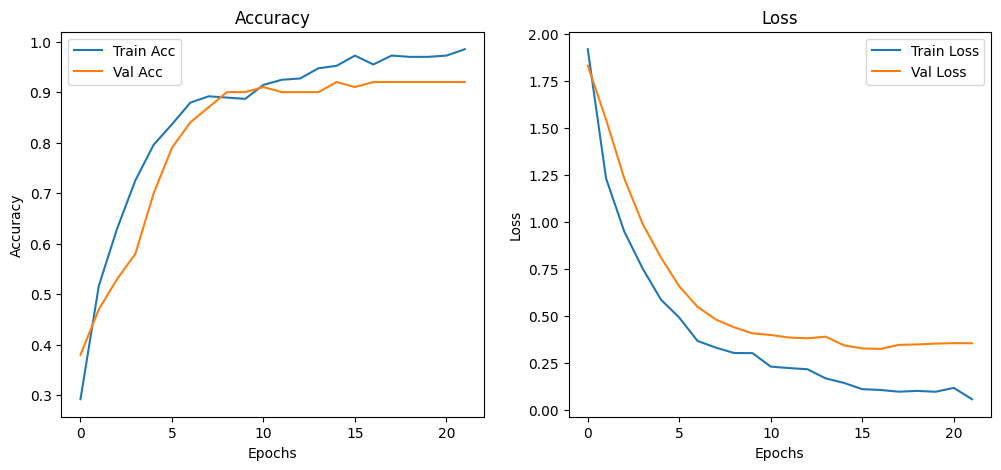

In [ ]:
# Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend(); plt.title("Accuracy"); plt.xlabel("Epochs"); plt.ylabel("Accuracy")

plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss"); plt.xlabel("Epochs"); plt.ylabel("Loss")
plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd # Import the pandas library



4/4 ━━━━━━━━━━━━━━━━━━━━ 39s 6s/step


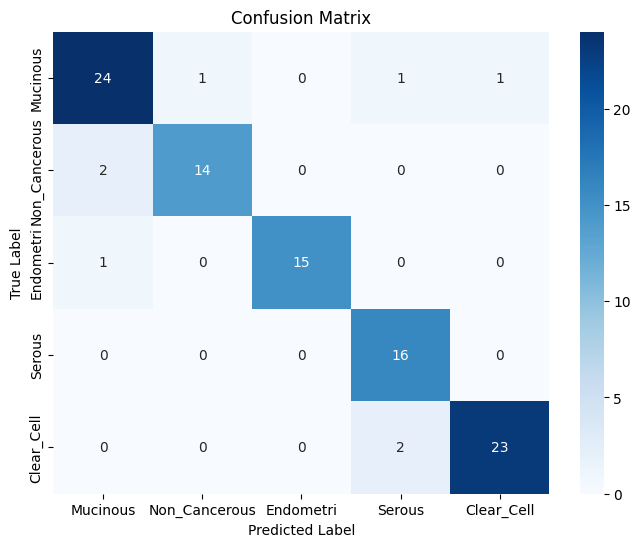

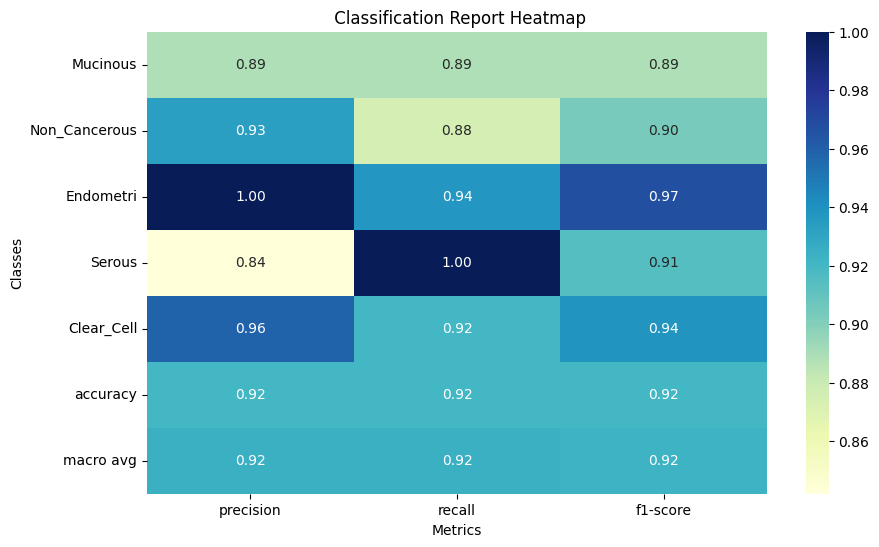

In [ ]:
# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report as heatmap
report = classification_report(y_true, y_pred_classes, target_names=classes, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10,6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title(" Classification Report Heatmap")
plt.ylabel("Classes")
plt.xlabel("Metrics")
plt.show()


efficientnetbo


In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# Imports
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Ensure this is imported
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [ ]:
# Dataset setup
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {class_name: i for i, class_name in enumerate(classes)}
IMG_SIZE = 224

X, y = [], []

In [ ]:
# Load and preprocess
for class_name in classes:
    class_path = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(class_path):
        continue
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Data Augmentation (Reduced)
datagen = ImageDataGenerator(
    rotation_range=20,  # Reduced range
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,  # Reduced zoom range
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = datagen.flow(X_train, y_train, batch_size=32)


In [ ]:
# Load base model
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers[:-10]:  # Unfreeze the last 10 layers instead of 20
    layer.trainable = False


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)  # Reduced dropout
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)  # Reduced dropout
output = Dense(len(classes), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
# Compile with a slightly higher learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Increased learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Callbacks
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=7,  # Reduced patience to allow faster convergence
    restore_best_weights=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Decreased factor
    patience=3,  # Increased patience
    verbose=1,
    min_lr=1e-6
)


In [ ]:
# Train with adjusted parameters
history = model.fit(
    train_generator,
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.8994 - loss: 0.3008 - val_accuracy: 0.8000 - val_loss: 0.5513 - learning_rate: 5.0000e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 4s/step - accuracy: 0.8941 - loss: 0.3092 - val_accuracy: 0.7700 - val_loss: 0.6241 - learning_rate: 5.0000e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9576 - loss: 0.1673 - val_accuracy: 0.7800 - val_loss: 0.5781 - learning_rate: 5.0000e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9508 - loss: 0.1192
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9493 - loss: 0.1222 - val_accuracy: 0.8000 - val_loss: 0.5772 - learning_rate: 5.0000e-04
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.9398 - loss: 0.2092 - val_accuracy: 0.7900 - val_loss: 0.5963 - learning_rate: 2.5000e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step - accuracy: 0.9469 - loss: 0.144

In [ ]:
# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\n🌟 Final Test Accuracy: {accuracy:.2f}")
print(f"📉 Final Test Loss: {loss:.4f}")

# Save the model
model.save("efficientnetb0_ovarian_model.keras")
print("✅ Model saved successfully!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.8551 - loss: 0.5202

🌟 Final Test Accuracy: 0.88
📉 Final Test Loss: 0.4399
✅ Model saved successfully!


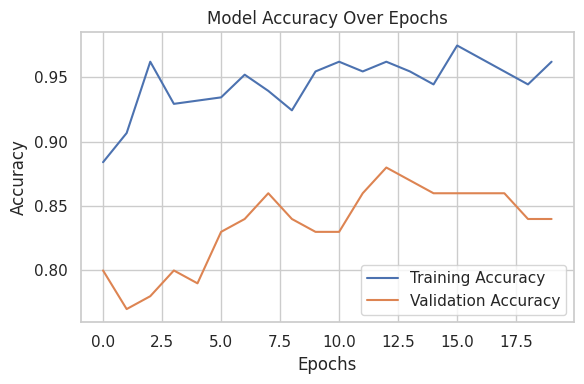

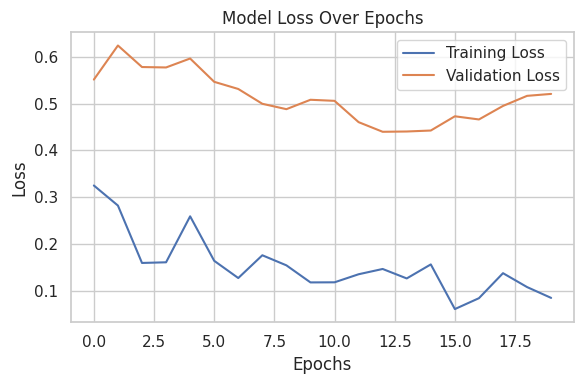

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid')  # for prettier seaborn plots
plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['accuracy'])), y=history.history['accuracy'], label='Training Accuracy')
sns.lineplot(x=range(len(history.history['val_accuracy'])), y=history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.lineplot(x=range(len(history.history['loss'])), y=history.history['loss'], label='Training Loss')
sns.lineplot(x=range(len(history.history['val_loss'])), y=history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()




In [ ]:
!ls


efficientnetb0_ovarian_model.keras  OvarianCancer  sample_data


In [ ]:
try:
    print(model.summary())
except:
    print("❌ No model named 'model' found in memory.")


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 7,821,588 (29.84 MB)

 Trainable params: 1,554,229 (5.93 MB)

 Non-trainable params: 3,158,899 (12.05 MB)

 Optimizer params: 3,108,460 (11.86 MB)

None


In [ ]:
model.save("densenet121_ovarian_cancer_final_model.h5")
print("🎉 DenseNet model saved successfully!")


🎉 DenseNet model saved successfully!


Ensemble model efficientnetbo and densenet121


In [ ]:
from tensorflow.keras.applications import EfficientNetB0, DenseNet121
from tensorflow.keras.models import load_model

# Load EfficientNetB0 model
efficientnet_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in efficientnet_model.layers[:-10]:
    layer.trainable = False

# Load DenseNet121 model
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in densenet_model.layers[:-10]:
    layer.trainable = False


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

# EfficientNetB0 custom layers
x = GlobalAveragePooling2D()(efficientnet_model.output)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
efficientnet_output = Dense(len(classes), activation='softmax')(x)

# DenseNet121 custom layers
y = GlobalAveragePooling2D()(densenet_model.output)
y = BatchNormalization()(y)
y = Dropout(0.3)(y)
y = Dense(512, activation='relu')(y)
y = Dropout(0.3)(y)
densenet_output = Dense(len(classes), activation='softmax')(y)


In [ ]:
from tensorflow.keras.layers import Concatenate

# Concatenate outputs
ensemble_output = Concatenate()([efficientnet_output, densenet_output])

# Final output layer
final_output = Dense(len(classes), activation='softmax')(ensemble_output)


In [ ]:
ensemble_model = Model(inputs=[efficientnet_model.input, densenet_model.input], outputs=final_output)


In [ ]:
from tensorflow.keras.optimizers import Adam

ensemble_model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = ensemble_model.fit(
    [X_train, X_train],  # Use both inputs (EfficientNet and DenseNet)
    y_train,
    validation_data=([X_test, X_test], y_test),
    epochs=30,
    callbacks=[early_stop, lr_scheduler]
)


Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 181s 11s/step - accuracy: 0.3272 - loss: 1.5215 - val_accuracy: 0.4600 - val_loss: 1.4485 - learning_rate: 0.0010
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - accuracy: 0.5453 - loss: 1.3546 - val_accuracy: 0.5400 - val_loss: 1.3568 - learning_rate: 0.0010
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 11s/step - accuracy: 0.6614 - loss: 1.2709 - val_accuracy: 0.6100 - val_loss: 1.3231 - learning_rate: 0.0010
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 142s 11s/step - accuracy: 0.7083 - loss: 1.2231 - val_accuracy: 0.6000 - val_loss: 1.3128 - learning_rate: 0.0010
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 143s 11s/step - accuracy: 0.7699 - loss: 1.1771 - val_accuracy: 0.6900 - val_loss: 1.2698 - learning_rate: 0.0010
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 202s 11s/step - accuracy: 0.8015 - loss: 1.1249 - val_accuracy: 0.7200 - val_loss: 1.2168 - learning_rate: 0.0010
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 141s 11s/step - accuracy: 0.8557 - loss: 1.0917 - 

In [ ]:
# Evaluate the ensemble model
loss, accuracy = ensemble_model.evaluate([X_test, X_test], y_test)
print(f"\n🌟 Final Test Accuracy: {accuracy:.2f}")
print(f"📉 Final Test Loss: {loss:.4f}")

# Save the ensemble model
ensemble_model.save("ensemble_ovarian_cancer_model.keras")
print("✅ Ensemble model saved successfully!")

4/4 ━━━━━━━━━━━━━━━━━━━━ 26s 5s/step - accuracy: 0.8760 - loss: 1.0155

🌟 Final Test Accuracy: 0.88
📉 Final Test Loss: 1.0013
✅ Ensemble model saved successfully!



VGG 19


1.   List item
2.   List item




In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:

from google.colab import files
files.upload()  # Upload your kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json



In [ ]:
!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip

Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# ✅ Imports
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.model_selection import train_test_split

In [ ]:
# ✅ Dataset setup
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}
IMG_SIZE = 128  # Reduced image size for faster processing

X, y = [], []

In [ ]:
# ✅ Load & preprocess images
for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        img = cv2.imread(image_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_input(img)
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Loaded {len(X)} images.")

✅ Loaded 497 images.


In [ ]:
# ✅ Load VGG19 base
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False  # Freeze all layers

# ✅ Add custom top layers
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.4)(x)
output = Dense(len(classes), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# ✅ Compile model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

# ✅ Data augmentation with minimal settings
datagen = ImageDataGenerator(
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)


In [ ]:

# ✅ Callbacks
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=2, verbose=1)
checkpoint = ModelCheckpoint("best_model.h5", monitor="val_accuracy", save_best_only=True, verbose=1)


In [ ]:
# ✅ Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    verbose=1
)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2717 - loss: 2.3951
Epoch 1: val_accuracy improved from -inf to 0.31000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.2711 - loss: 2.3961 - val_accuracy: 0.3100 - val_loss: 2.1329 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2910 - loss: 2.2516
Epoch 2: val_accuracy improved from 0.31000 to 0.39000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 182s 5s/step - accuracy: 0.2901 - loss: 2.2550 - val_accuracy: 0.3900 - val_loss: 1.6993 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3282 - loss: 2.0551
Epoch 3: val_accuracy improved from 0.39000 to 0.46000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 123s 5s/step - accuracy: 0.3279 - loss: 2.0569 - val_accuracy: 0.4600 - val_loss: 1.5034 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3352 - loss: 1.9752
Epoch 4: val_accuracy improved from 0.46000 to 0.47000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.3344 - loss: 1.9770 - val_accuracy: 0.4700 - val_loss: 1.3792 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3678 - loss: 1.8554
Epoch 5: val_accuracy improved from 0.47000 to 0.51000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 145s 6s/step - accuracy: 0.3678 - loss: 1.8544 - val_accuracy: 0.5100 - val_loss: 1.2910 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3515 - loss: 1.7387
Epoch 6: val_accuracy improved from 0.51000 to 0.55000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.3517 - loss: 1.7389 - val_accuracy: 0.5500 - val_loss: 1.2305 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3971 - loss: 1.6513
Epoch 7: val_accuracy improved from 0.55000 to 0.61000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 124s 5s/step - accuracy: 0.3989 - loss: 1.6483 - val_accuracy: 0.6100 - val_loss: 1.1878 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4169 - loss: 1.6549
Epoch 8: val_accuracy improved from 0.61000 to 0.62000, saving model to best_model.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.4170 - loss: 1.6550 - val_accuracy: 0.6200 - val_loss: 1.1543 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4340 - loss: 1.6457
Epoch 9: val_accuracy did not improve from 0.62000
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.4339 - loss: 1.6419 - val_accuracy: 0.6100 - val_loss: 1.1288 - learning_rate: 1.0000e-04
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4515 - loss: 1.4282
Epoch 10: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 10: val_accuracy did not improve from 0.62000
25/25 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.4517 - loss: 1.4278 - val_accuracy: 0.6200 - val_loss: 1.1102 - learning_rate: 1.0000e-04
Epoch 11/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.4353 - loss: 1.4944
Epoch 11: val_accuracy did not improve from 0.62000
25/25 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.4358 - loss: 1.4939 - val_accu

In [ ]:
# ✅ Evaluate model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"🎯 Final Test Accuracy: {accuracy:.4f}")
print(f"💾 Final Test Loss: {loss:.4f}")

# ✅ Save model
model.save("vgg19_tuned_ovarian_model.h5")
print("✅ Model saved as 'vgg19_tuned_ovarian_model.h5'")


4/4 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step - accuracy: 0.6168 - loss: 1.1901


🎯 Final Test Accuracy: 0.6200
💾 Final Test Loss: 1.1543
✅ Model saved as 'vgg19_tuned_ovarian_model.h5'


ensemble vgg19 and densenet121

In [ ]:
!pip install kaggle tensorflow numpy pandas opencv-python matplotlib scikit-learn

In [ ]:
from google.colab import files
files.upload()  # Upload your kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nowrinjahan","key":"d1ec15a71452182fae5fb36e49423992"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:

!kaggle datasets download -d bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology --unzip


Dataset URL: https://www.kaggle.com/datasets/bitsnpieces/ovarian-cancer-and-subtypes-dataset-histopathology
License(s): CC-BY-SA-4.0


In [ ]:
# ✅ Imports
import os, cv2, numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG19, DenseNet121
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet

# ✅ Constants
IMG_SIZE = 128
DATASET_PATH = "OvarianCancer"
classes = ["Mucinous", "Non_Cancerous", "Endometri", "Serous", "Clear_Cell"]
class_mapping = {name: i for i, name in enumerate(classes)}
X, y = [], []

# ✅ Load and preprocess images
for class_name in classes:
    folder = os.path.join(DATASET_PATH, class_name)
    if not os.path.exists(folder): continue
    for image_name in os.listdir(folder):
        image_path = os.path.join(folder, image_name)
        img = cv2.imread(image_path)
        if img is None: continue
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = preprocess_vgg(img)  # VGG & DenseNet use similar preprocessing
        X.append(img)
        y.append(class_mapping[class_name])

X = np.array(X)
y = to_categorical(y, num_classes=len(classes))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("✅ Image data prepared:", X.shape)

# ✅ Load VGG19 model
vgg_base = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in vgg_base.layers:
    layer.trainable = False
vgg_out = GlobalAveragePooling2D()(vgg_base.output)
vgg_out = BatchNormalization()(vgg_out)
vgg_out = Dropout(0.5)(vgg_out)

# ✅ Load DenseNet121 model
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in densenet_base.layers:
    layer.trainable = False
densenet_out = GlobalAveragePooling2D()(densenet_base.output)
densenet_out = BatchNormalization()(densenet_out)
densenet_out = Dropout(0.5)(densenet_out)

# ✅ Merge both model outputs
merged = Concatenate()([vgg_out, densenet_out])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.4)(merged)
final_output = Dense(len(classes), activation='softmax')(merged)

# ✅ Build final ensemble model
ensemble_model = Model(inputs=[vgg_base.input], outputs=final_output)
ensemble_model.summary()


✅ Image data prepared: (497, 128, 128, 3)
80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 27,462,789 (104.76 MB)

 Trainable params: 397,829 (1.52 MB)

 Non-trainable params: 27,064,960 (103.24 MB)

In [ ]:
# ✅ Optimizer
optimizer = Adam(learning_rate=0.0001)

# ✅ Label smoothing loss
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

# ✅ Compile model
ensemble_model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

In [ ]:
# ✅ Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# ✅ Class weights (to balance uneven data, if needed)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

y_labels = np.argmax(y_train, axis=1)
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_labels), y=y_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}
print("✅ Class Weights:", class_weights_dict)

# ✅ Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
checkpoint = ModelCheckpoint("ensemble_best_model.h5", monitor='val_accuracy', save_best_only=True)


✅ Class Weights: {0: np.float64(1.0876712328767124), 1: np.float64(0.9566265060240964), 2: np.float64(0.9682926829268292), 3: np.float64(0.9452380952380952), 4: np.float64(1.0586666666666666)}


In [ ]:
from tensorflow.keras.layers import Input

# ✅ Create separate input
input_layer = Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# ✅ VGG19 branch
vgg_base = VGG19(weights='imagenet', include_top=False, input_tensor=input_layer)
for layer in vgg_base.layers:
    layer.trainable = False
vgg_out = GlobalAveragePooling2D()(vgg_base.output)
vgg_out = BatchNormalization()(vgg_out)
vgg_out = Dropout(0.5)(vgg_out)

# ✅ DenseNet branch
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_layer)
for layer in densenet_base.layers:
    layer.trainable = False
densenet_out = GlobalAveragePooling2D()(densenet_base.output)
densenet_out = BatchNormalization()(densenet_out)
densenet_out = Dropout(0.5)(densenet_out)

# ✅ Merge outputs
merged = Concatenate()([vgg_out, densenet_out])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.4)(merged)
final_output = Dense(len(classes), activation='softmax')(merged)

# ✅ Final model
ensemble_model = Model(inputs=input_layer, outputs=final_output)


In [ ]:
# ✅ Final model (from previous step)
ensemble_model = Model(inputs=input_layer, outputs=final_output)

# ✅ Compile model after creating it
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)
loss_fn = CategoricalCrossentropy(label_smoothing=0.1)

ensemble_model.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=["accuracy"]
)


In [ ]:
# ✅ Train model
history = ensemble_model.fit(
    datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_test, y_test),
    epochs=30,
    callbacks=[early_stop, reduce_lr, checkpoint],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.2277 - loss: 2.5892

25/25 ━━━━━━━━━━━━━━━━━━━━ 167s 7s/step - accuracy: 0.2293 - loss: 2.5825 - val_accuracy: 0.3700 - val_loss: 2.0375 - learning_rate: 1.0000e-04
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.3619 - loss: 2.0899

25/25 ━━━━━━━━━━━━━━━━━━━━ 183s 6s/step - accuracy: 0.3619 - loss: 2.0858 - val_accuracy: 0.4600 - val_loss: 1.6771 - learning_rate: 1.0000e-04
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 166s 7s/step - accuracy: 0.3450 - loss: 2.0203 - val_accuracy: 0.4400 - val_loss: 1.5588 - learning_rate: 1.0000e-04
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4960 - loss: 1.7426

25/25 ━━━━━━━━━━━━━━━━━━━━ 152s 6s/step - accuracy: 0.4954 - loss: 1.7418 - val_accuracy: 0.4800 - val_loss: 1.4760 - learning_rate: 1.0000e-04
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 208s 6s/step - accuracy: 0.4597 - loss: 1.7013 - val_accuracy: 0.4700 - val_loss: 1.4669 - learning_rate: 1.0000e-04
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 158s 6s/step - accuracy: 0.5350 - loss: 1.5484 - val_accuracy: 0.4800 - val_loss: 1.4656 - learning_rate: 1.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.5155 - loss: 1.5070 - val_accuracy: 0.4800 - val_loss: 1.4700 - learning_rate: 1.0000e-04
Epoch 8/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 148s 6s/step - accuracy: 0.5269 - loss: 1.4484 - val_accuracy: 0.4600 - val_loss: 1.4589 - learning_rate: 1.0000e-04
Epoch 9/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 150s 6s/step - accuracy: 0.5596 - loss: 1.4768 - val_accuracy: 0.4700 - val_loss: 1.4661 - learning_rate: 1.0000e-04
Epoch 10/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 162s 7s/step - accuracy: 0.5197 - loss: 1.

25/25 ━━━━━━━━━━━━━━━━━━━━ 165s 7s/step - accuracy: 0.5701 - loss: 1.3248 - val_accuracy: 0.5100 - val_loss: 1.5257 - learning_rate: 1.0000e-04
Epoch 12/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.5077 - loss: 1.4717

25/25 ━━━━━━━━━━━━━━━━━━━━ 147s 6s/step - accuracy: 0.5090 - loss: 1.4700 - val_accuracy: 0.5200 - val_loss: 1.5350 - learning_rate: 2.0000e-05
Epoch 13/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.5536 - loss: 1.4199 - val_accuracy: 0.5000 - val_loss: 1.5362 - learning_rate: 2.0000e-05


In [ ]:
# Step 10: Evaluate the model
loss, accuracy = ensemble_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test Loss: {loss:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 36s 7s/step - accuracy: 0.4111 - loss: 1.5213
Test Accuracy: 46.00%
Test Loss: 1.4589


In [ ]:
# Save the entire model
ensemble_model.save('ensemble_model.h5')
